In [96]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from autogluon.tabular import TabularPredictor

# Modelos Tradicionais (Baseline)
# 📊ARIMA
#### 💾 Carregamento e preparação da série temporal

In [97]:
df = pd.read_parquet('datasets/consumo_eredes_normalizado.parquet')

# Filtrar CP 4610 e ordenar
df_cp = df[df["ZipCode"] == "4610"].copy()
df_cp["DateTime"] = pd.to_datetime(df_cp["DateTime"])
df_cp = df_cp.sort_values("DateTime")

# Filtra os dados para o código postal 4610 e garante que as datas estão no tipo datetime e ordenadas cronologicamente.
static_feats = df_cp[["ZipCode","PopulationDensity"]].drop_duplicates()

# Extrai as static features, neste caso a densidade populacional por código postal, que não variam ao longo do tempo.
ts_df = TimeSeriesDataFrame.from_data_frame(
    df_cp, id_column="ZipCode",
    timestamp_column="DateTime",
    static_features_df=static_feats
)

#### 🧪 Separação treino / teste

In [98]:
# Separa os dados em treino e teste. As últimas 24 horas são reservadas para teste (hold-out).
train_data, test_data = ts_df.train_test_split(prediction_length=24)

#### 💾 (Opcional) Carregar um modelo existente

In [100]:
# Tenta carregar um modelo previamente treinado para reaproveitamento ou análise.
predictor_arima = TimeSeriesPredictor.load("./predicts/ARIMA/modelo/")

Loading predictor from path D:\githubProjects\previsao-do-consumo-energetico-com-ml\predicts\ARIMA\modelo


#### 🛠️ Treinar ARIMA puro (sem covariáveis)

In [99]:
# Treina o modelo ARIMA com ordem (1,1,1) e sazonalidade diária (24 horas).
# Usa normalização (target_scaler: standard) e ignora ensemble/model selection (skip_model_selection=True) para forçar o uso exclusivo do ARIMA.
predictor_arima = TimeSeriesPredictor(
    target="EnergyNormalized",
    prediction_length=24,
    freq="h",
    path="predicts/ARIMA/modelo"
).fit(
    train_data,
    tuning_data=test_data,
    hyperparameters={
        "ARIMAModel": {
            "order": (1, 1, 1),
            "seasonal_order": (1, 0, 1, 24),
            "target_scaler": "standard",
        }
    },
    time_limit=300,
    presets="medium_quality",
    skip_model_selection=True,    # não tenta ensembles
)

predictor_arima.save() # Guarda o modelo treinado para reutilização futura

Beginning AutoGluon training... Time limit = 300s
AutoGluon will save models to 'D:\githubProjects\previsao-do-consumo-energetico-com-ml\predicts\ARIMA\modelo'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.9
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
GPU Count:          0
Memory Avail:       2.09 GB / 15.93 GB (13.1%)
Disk Space Avail:   701.42 GB / 931.46 GB (75.3%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'h',
 'hyperparameters': {'ARIMAModel': {'order': (1, 1, 1),
                                    'seasonal_order': (1, 0, 1, 24),
                                    'target_scaler': 'standard'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 24,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,


#### 🔮 Previsão com os dados de treino

In [101]:
future_preds = predictor_arima.predict(train_data) # Gera previsões futuras com base nos dados de treino (últimas 24h).

# Extrai a previsão pontual (mediana, coluna "0.5") e remove o nível do índice correspondente ao código postal.
y_pred = future_preds["0.5"]
y_pred = y_pred.droplevel(0)

Model not specified in predict, will default to the model with the best validation score: ARIMA


#### ✅ Preparar dados reais para comparação

In [102]:
# Cria os dados reais correspondentes ao dia 30/09/2023 para comparar com as previsões.
mask = ((df_cp["ZipCode"]=="4610") & (df_cp["DateTime"].between("2023-09-30 00:00","2023-09-30 23:00")))

df_true = df_cp.loc[mask, ["DateTime","EnergyNormalized"]] \
               .set_index("DateTime")

y_true = df_true["EnergyNormalized"]

#### 📊  Avaliação do modelo

In [103]:
# Avalia o desempenho do modelo com as métricas internas do AutoGluon.
metrics = predictor_arima.evaluate(test_data)

# Calcula métricas personalizadas: MAE, MSE, RMSE e MAPE.
mae  = mean_absolute_error(y_true, y_pred)
mse  = mean_squared_error(y_true, y_pred)
rmse = mse**0.5
mape = (abs((y_true - y_pred) / y_true) * 100).mean()

print(f"MAE:  {mae:.5f}")
print(f"MSE:  {mse:.5f}")
print(f"RMSE: {rmse:.5f}")
print(f"MAPE: {mape:.5f}%")

Model not specified in predict, will default to the model with the best validation score: ARIMA


MAE:  0.02499
MSE:  0.00097
RMSE: 0.03117
MAPE: 47.82159%


### 📊 **Métricas de Avaliação**

| Métrica                                      | Valor   | Interpretação |
|----------------------------------------------|---------|---------------|
| **MAE** (Erro Absoluto Médio)                | 0.02499 |               |
| **MSE** (Erro Quadrático Médio)              | 0.00097 |               |
| **RMSE** (Raiz do Erro Quadrático Médio)     | 0.03117 |               |
| **MAPE** (Erro Percentual Absoluto Médio)    | 47.82%  |               |

#### 📈 Visualização dos resultados

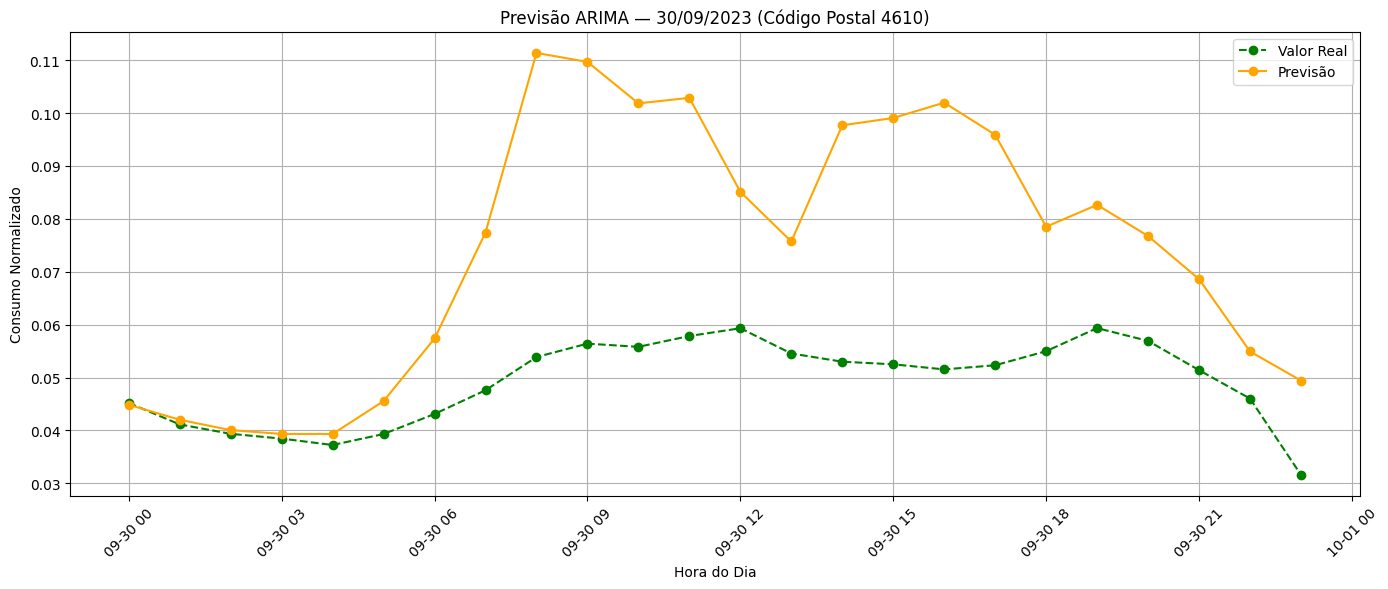

In [104]:
# Compara graficamente as previsões com os valores reais do consumo energético.
timestamps = future_preds.index.get_level_values("timestamp")

plt.figure(figsize=(14, 6))
plt.plot(timestamps, y_true, label="Valor Real", marker='o', linestyle='--', color='green')
plt.plot(timestamps, y_pred, label="Previsão", marker='o', color='orange')
plt.xlabel("Hora do Dia")
plt.ylabel("Consumo Normalizado")
plt.xticks(rotation=45)
plt.grid(True)
plt.title("Previsão ARIMA — 30/09/2023 (Código Postal 4610)")
plt.legend()
plt.tight_layout()
plt.savefig("predicts/ARIMA/grafico.png", dpi=300, bbox_inches='tight')
plt.show()

# 📊XARIMA com variáveis exógenas

#### 📦 Carregamento e preparação dos dados

In [105]:
# Carrega os dados e filtra para o código postal 4610, ordenando-os por data.
df = pd.read_parquet("./datasets/consumo_eredes_normalizado.parquet")

# Filtrar CP 4610 e ordenar
df_cp = df[df["ZipCode"] == "4610"].copy()
df_cp["DateTime"] = pd.to_datetime(df_cp["DateTime"])
df_cp = df_cp.sort_values("DateTime")

# Crie um DataFrame de features estáticas único por série:
static_feats = (
    df_cp[["ZipCode", "PopulationDensity"]]
    .drop_duplicates()   # agora tem apenas 1 linha: ZipCode 4610
    .copy()
)

# Extrai as features estáticas da série (como densidade populacional).
ts_df = TimeSeriesDataFrame.from_data_frame(
    df_cp,
    id_column="ZipCode",
    timestamp_column="DateTime",
    static_features_df=static_feats
)

# Constrói o TimeSeriesDataFrame com colunas de tempo, id e features estáticas.
known_covs = ["Hour","TimeOfDay", "Temperature", "DayOfTheWeek"]

#### ✂️ Split treino/teste

In [106]:
# Divide os dados em treino e teste, reservando as últimas 24h como hold-out.
train_data, test_data = ts_df.train_test_split(prediction_length=24)

#### 💾 Carregamento e/ou treino do modelo XARIMA

In [108]:
# (Opcional) Carrega um modelo previamente treinado.
predictor_xarima = TimeSeriesPredictor.load("./predicts/XARIMA/modelo/")

Loading predictor from path D:\githubProjects\previsao-do-consumo-energetico-com-ml\predicts\XARIMA\modelo


In [67]:
# Treina um modelo ARIMA com CATBoost como regressor de covariáveis.
# known_covariates_names especifica as variáveis exógenas.
# O target_scaler normaliza a série temporal alvo.
predictor_xarima = TimeSeriesPredictor(
    target="EnergyNormalized",
    prediction_length=24,
    freq="h",
    known_covariates_names=known_covs,
    path="predicts/XARIMA/modelo"
).fit(
    train_data,
    tuning_data=test_data,
    hyperparameters={
        "ARIMAModel": {
            "covariate_regressor": "CAT",
            "target_scaler": "standard",
        }
    },
    time_limit=300,
    presets="medium_quality",
)

predictor_xarima.save() # Guarda o modelo treinado.

Beginning AutoGluon training... Time limit = 300s
AutoGluon will save models to 'D:\githubProjects\previsao-do-consumo-energetico-com-ml\predicts\XARIMA\modelo'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.9
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
GPU Count:          0
Memory Avail:       3.78 GB / 15.93 GB (23.7%)
Disk Space Avail:   701.42 GB / 931.46 GB (75.3%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'h',
 'hyperparameters': {'ARIMAModel': {'covariate_regressor': 'CAT',
                                    'target_scaler': 'standard'}},
 'known_covariates_names': ['Hour', 'TimeOfDay', 'Temperature', 'DayOfTheWeek'],
 'num_val_windows': 1,
 'prediction_length': 24,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_

#### 🔮Preparação das covariáveis futuras para previsão

In [109]:
# Gera os timestamps das próximas 24 horas.
# Filtra e monta o DataFrame com as covariáveis conhecidas correspondentes.
last_time = train_data.index.get_level_values("timestamp").max()
future_times = pd.date_range(
    start=last_time + pd.Timedelta(hours=1),
    periods=24,
    freq="h"
)

# 2) fatie o df_cp nessas datas:
df_future_covs = df_cp.loc[
    df_cp["DateTime"].isin(future_times),
    ["ZipCode", "DateTime"] + known_covs
].copy()

# 3) montar o TimeSeriesDataFrame só com essas covariáveis:
future_known_covs = TimeSeriesDataFrame.from_data_frame(
    df_future_covs,
    id_column="ZipCode",
    timestamp_column="DateTime"
)[known_covs]

#### 📈 Previsão e avaliação

In [110]:
# Faz a previsão para o futuro com base nos dados de treino e covariáveis futuras.
preds = predictor_xarima.predict(
    data=train_data,
    known_covariates=future_known_covs
)

# Extrai a previsão pontual (mediana) e os valores reais correspondentes.
y_pred = preds["0.5"]
y_true = test_data["EnergyNormalized"].loc[preds.index]
metrics = predictor_xarima.evaluate(test_data)
print("WQL hold‑out com Temperature exógena:", metrics["WQL"])

Model not specified in predict, will default to the model with the best validation score: ARIMA
Model not specified in predict, will default to the model with the best validation score: ARIMA


WQL hold‑out com Temperature exógena: -0.08521395429261237


#### 📊 Cálculo de métricas

In [111]:
# Se quiser um array simples:
y_true = y_true.reset_index(drop=True)
y_pred = y_pred.reset_index(drop=True)

n = len(y_true)
assert n == len(y_pred), "y_true e y_pred devem ter mesmo tamanho"

# Erros
abs_errs    = np.abs(y_true - y_pred)
sq_errs     = (y_true - y_pred) ** 2
pct_errs    = np.abs((y_true - y_pred) / y_true) * 100  # em %

# Métricas
MAE  = abs_errs.mean()
MSE  = sq_errs.mean()
RMSE = np.sqrt(MSE)
MAPE = pct_errs.mean()

print(f'MAE: {MAE:.5f}')
print(f'MSE: {MSE:.5f}')
print(f'RMSE: {RMSE:.5f}')
print(f'MAPE: {MAPE:.5f}%')

MAE: 0.00250
MSE: 0.00001
RMSE: 0.00355
MAPE: 5.55549%


### 📊 **Métricas de Avaliação**

| Métrica                                      | Valor   | Interpretação                                                                                                                                                                                                  |
|----------------------------------------------|---------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **MAE** (Erro Absoluto Médio)                | 0.00250 | O erro médio absoluto é muito baixo, indicando que as previsões feitas pelo XARIMA estão, em média, apenas 0.00250 unidades afastadas dos valores reais — um excelente resultado.                              |
| **MSE** (Erro Quadrático Médio)              | 0.00001 | O erro quadrático médio também é bastante reduzido, o que indica que grandes desvios entre previsão e realidade são raros. O modelo tem bom desempenho mesmo nos extremos.                                     |
| **RMSE** (Raiz do Erro Quadrático Médio)     | 0.00355 | Este valor representa o erro médio esperado com a mesma unidade da variável alvo (consumo normalizado). Um RMSE inferior a 0.00355 confirma que o modelo prevê com alta precisão.                              |
| **MAPE** (Erro Percentual Absoluto Médio)    | 5.55%   | O erro percentual médio é apenas quase 6%, o que indica uma excelente capacidade preditiva. Em média, o modelo erra apenas quase 6% em relação ao valor real, o que é considerado ótimo para séries temporais. |

#### 🖼️ Visualização gráfica

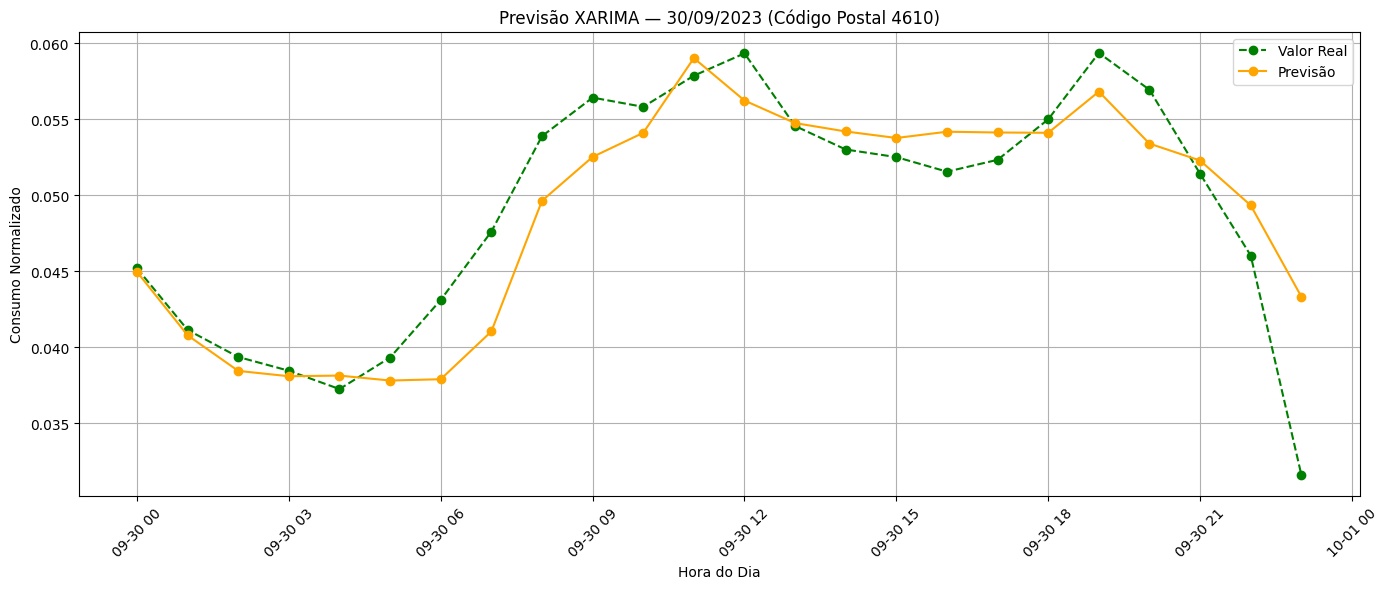

In [112]:
# Extrair os timestamps do índice
timestamps = preds.index.get_level_values("timestamp")

plt.figure(figsize=(14, 6))
plt.plot(timestamps, y_true, label="Valor Real", marker='o', linestyle='--', color='green')
plt.plot(timestamps, y_pred, label="Previsão", marker='o', color='orange')
plt.xlabel("Hora do Dia")
plt.ylabel("Consumo Normalizado")
plt.xticks(rotation=45)
plt.grid(True)
plt.title("Previsão XARIMA — 30/09/2023 (Código Postal 4610)")
plt.legend()
plt.tight_layout()
plt.savefig("predicts/XARIMA/grafico.png", dpi=300, bbox_inches='tight')
plt.show()

# 📊Regressão Linear (usando features temporais)
#### 📦 Carregamento e preparação dos dados

In [113]:
# Carrega os dados e filtra para o código postal 4610, ordenando-os por data.
df = pd.read_parquet("./datasets/consumo_eredes_normalizado.parquet")

# Filtrar CP 4610 e ordenar
df_cp = df[df["ZipCode"] == "4610"].copy()
df_cp["DateTime"] = pd.to_datetime(df_cp["DateTime"])
df_cp = df_cp.sort_values("DateTime")

mask = (
    (df_cp["ZipCode"]=="4610") &
    (df_cp["DateTime"].between("2023-09-30 00:00","2023-09-30 23:00"))
)

# Série de datas para o eixo x
timestamps = df_cp.loc[mask, "DateTime"].reset_index(drop=True)

features = ["Hour","TimeOfDay", "Temperature", "DayOfTheWeek"]
df_tab = df_cp[features+["EnergyNormalized","DateTime"]].copy()

#### ✂️ Split treino/teste

In [114]:
# split: tudo antes de 2023‑09‑30 como treino, 30‑09 como teste
train = df_tab[df_tab.DateTime < "2023-09-30"].drop(columns="DateTime")
test  = df_tab[df_tab.DateTime >= "2023-09-30"].drop(columns="DateTime")

#### 💾 Carregamento do modelo

In [115]:
# (Opcional) Carrega um modelo previamente treinado.
predictor_linear_regression = TabularPredictor.load("predicts/linearRegression/modelo")

#### 🛠️ Treinar

In [88]:
# Treina um LinearModel via AutoGluon
predictor_linear_regression = TabularPredictor(
    label="EnergyNormalized",
    eval_metric="mean_absolute_error",
        path="predicts/linearRegression/modelo"
).fit(
    train_data=train,
    tuning_data=test,
    hyperparameters={"LR": {}},
    time_limit=300,
    presets="medium"
)

predictor_linear_regression.save() # Guarda o modelo treinado.

Preset alias specified: 'medium' maps to 'medium_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.9
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
Memory Avail:       2.27 GB / 15.93 GB (14.3%)
Disk Space Avail:   701.42 GB / 931.46 GB (75.3%)
Presets specified: ['medium']
Beginning AutoGluon training ... Time limit = 300s
AutoGluon will save models to "D:\githubProjects\previsao-do-consumo-energetico-com-ml\predicts\linearRegression\modelo"
Train Data Rows:    7992
Train Data Columns: 4
Tuning Data Rows:    24
Tuning Data Columns: 4
Label Column:       EnergyNormalized
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (0.1517218738549846, 0.005890280091559903, 0.06812, 0.02939)
	If 'regression' is not the cor

#### 📈 Previsão e avaliação

In [116]:
# 2.3) Avalia
y_true = test.EnergyNormalized.reset_index(drop=True)
y_pred = predictor_linear_regression.predict(test).reset_index(drop=True)
mae  = mean_absolute_error(y_true, y_pred)
mse  = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = (np.abs((y_true - y_pred)/y_true)*100).mean()

print(f"MAE:  {mae:.5f}")
print(f"MSE:  {mse:.5f}")
print(f"RMSE: {rmse:.5f}")
print(f"MAPE: {mape:.5f}%")

MAE:  0.01241
MSE:  0.00024
RMSE: 0.01565
MAPE: 27.47892%


### 📊 **Métricas de Avaliação**

| Métrica                                      | Valor   | Interpretação                                                                                                                                                                       |
|----------------------------------------------|---------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **MAE** (Erro Absoluto Médio)                | 0.01241 | Em média, o modelo de regressão linear errou cerca de 0.0124 unidades de consumo normalizado por hora. Embora seja melhor que o ARIMA puro, está ainda longe da precisão do XARIMA. |
| **MSE** (Erro Quadrático Médio)              | 0.00024 | O erro quadrático médio mostra que há erros mais significativos em certos períodos (como saltos bruscos), penalizando previsões fora do padrão.                                     |
| **RMSE** (Raiz do Erro Quadrático Médio)     | 0.01565 | Representa o erro médio com a mesma unidade da variável alvo. Um valor de 0.016 indica uma dispersão maior das previsões face aos valores reais, especialmente nos extremos.        |
| **MAPE** (Erro Percentual Absoluto Médio)    | 27.48%  | O modelo erra, em média, cerca de 27.5% em relação aos valores reais. É uma melhoria face ao ARIMA puro (48%), mas ainda um desempenho fraco face ao XARIMA (5.55%).                |

#### 🖼️ Visualização gráfica

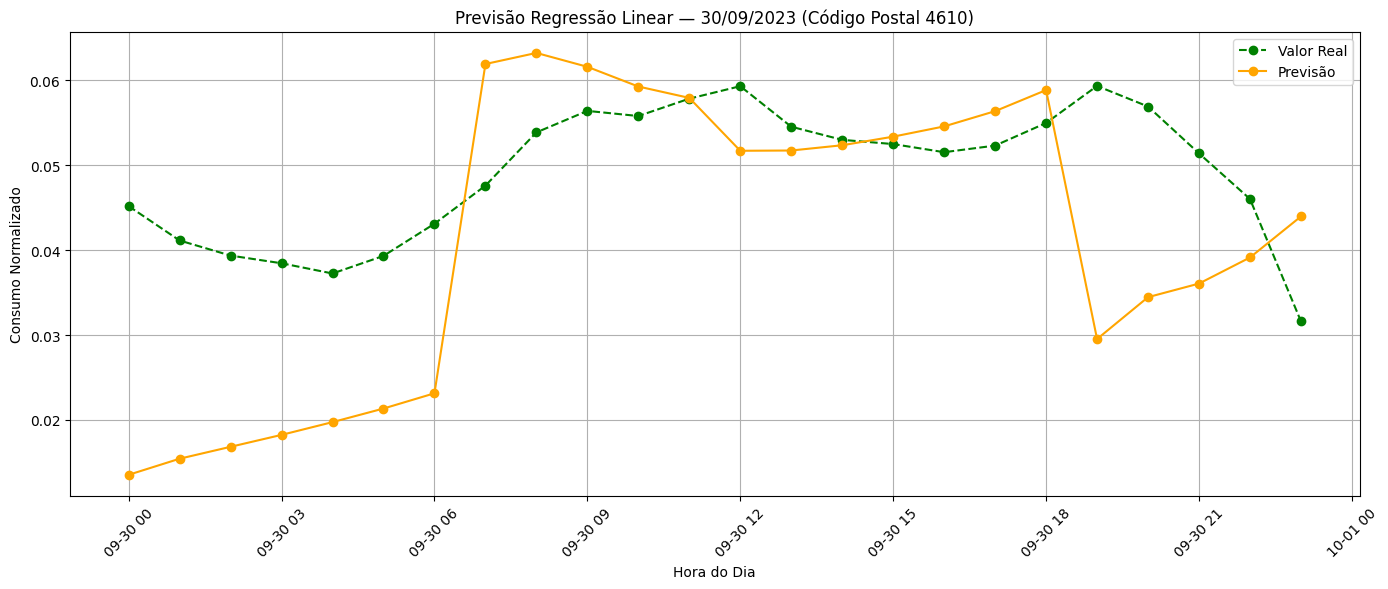

In [117]:
plt.figure(figsize=(14, 6))
plt.plot(timestamps, y_true, label="Valor Real", marker='o', linestyle='--', color='green')
plt.plot(timestamps, y_pred, label="Previsão", marker='o', color='orange')
plt.xlabel("Hora do Dia")
plt.ylabel("Consumo Normalizado")
plt.xticks(rotation=45)
plt.grid(True)
plt.title("Previsão Regressão Linear — 30/09/2023 (Código Postal 4610)")
plt.legend()
plt.tight_layout()
plt.savefig("predicts/linearRegression/grafico.png", dpi=300, bbox_inches='tight')
plt.show()